<a href="https://colab.research.google.com/github/emaudealtema/Machine_Learning_repo/blob/master/classification_des_plantes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Surface fault classification of industrial products using the "bag of word" model

Overview: In this exercise, we will in turn practice the steps to build a machine learning system for the problem of classifying the surface of industrial products: feature extraction, building classification model, classification type on actual image. The exercise requires knowledge of Python programming with libraries: OpenCV, scikit-learn, pickle, numpy.

In case you have not successfully installed opencv contrib, run the following commands on the terminal window:
pip uninstall opencv-contrib-python
pip uninstall opencv-python
pip install opencv-python == 3.4.0.12
pip install opencv-contrib-python == 3.4.0.12
pip uninstall numpy
pip install numpy == 1.15.2

## Check openCV library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/'My Drive'/tp2/BOW2

/content/drive/My Drive/tp2/BOW2


## Declare library

In [ ]:
!pip install opencv-contrib-python==4.4.0.44
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pickle
import sklearn

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

     |████████████████████████████████| 55.7MB 80kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


## Read image data from folder

In [ ]:
dataDir='./Data_Feuille/'
classes=['F9', 'F8', 'F7', 'F6', 'F5', 'F4','F30', 'F3', 'F29', 'F28', 'F27', 'F26', 'F25']

In [ ]:
# Defines the function to load data
def LoadData(dataDir,new_size=None):
    if not new_size is None:
        img_rows, img_cols = new_size
    classes=[]
    for _,dirs,_ in os.walk(dataDir):
        classes=dirs # The number of primary classes is equal to the number of subdirectories
        break  
    num_classes=len(classes)    
    ValidPercent=30  # 30% of the images in 1 class will be used for the test and the rest is for training
    X_tr=[]
    Y_tr=[]
    X_te=[]
    Y_te=[]    
    for idx,cl in enumerate(classes):
        for _,_,files in os.walk(dataDir+cl+'/'):               
            l=len(files)
            for f in files:
              # Randomly take a number from 0 to 100 to decide whether to use this sample to train or test
                r=np.random.randint(100) 
                img_path=dataDir+cl+'/'+f
                img=cv.imread(img_path)
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                if not new_size is None:
                    img=cv.resize(img,(img_rows,img_cols))
                if (r>ValidPercent):
                    X_tr.append(img)
                    Y_tr.append(idx)  
                else:
                    X_te.append(img)
                    Y_te.append(idx)                      
    return X_tr, Y_tr, X_te, Y_te

img for train: 542 (Sử dụng tạo từ điển và khâu huấn luyện)
label for train: 542
img for test: 242
label for test: 242


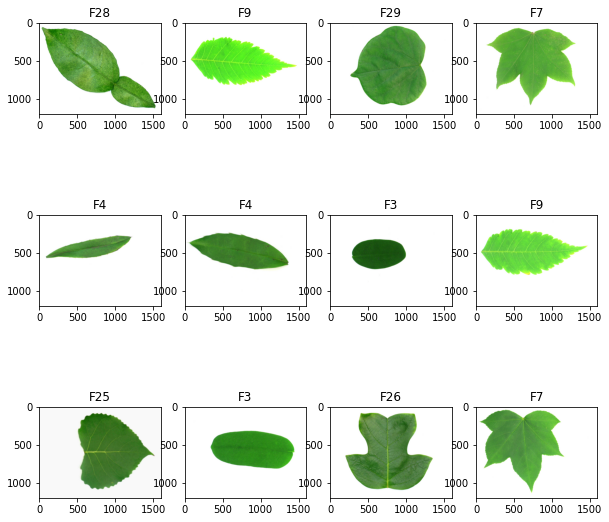

In [ ]:
new_size=(256,256)
img_train,label_train, img_test, label_test=LoadData(dataDir,None)
"""
Some information of the data
"""
print("img for train: %d (Sử dụng tạo từ điển và khâu huấn luyện)" % (len(img_train)))
print("label for train: %d" % (len(label_train)))

print("img for test: %d" % (len(img_test)))
print("label for test: %d" % (len(label_test)))

# Randomly display 12 sample images
idxs=np.random.permutation(len(img_train))
plt.figure(figsize = (10,10))
for i in range(12): # Randomly take 12 samples in train
    idx=idxs[i]
    plt.subplot(3,4,i+1)
    plt.imshow(img_train[idx])
    plt.title(classes[label_train[idx]])
plt.show()

## Feature building

Here we will do the following tasks: extract the SIFT feature (SIFT keypoints descriptor), build a dictionary and a Bag-of-Word (BoW) model. Only use the training set

### SIFT or SURF feature extraction (local)

The extract_sift_features () function takes the input of the image list we built from the previous question and returns the list image_descriptors, the pth element in the list image_descriptors is a list containing the SIFT keypoints descriptor corresponding to the pth image in list X.

To initialize the SIFT object in OpenCV we use the command: sift = cv2.xfeatures2d.SIFT_create (). This object has a detectAndCompute method that returns 2 outputs kp and des, kp is a list containing keypoints detected by SIFT, des is a numpy array containing len (kp) 128-dimensional vectors. We will use these des to serve the classification problem.

In [ ]:
def extract_sift_features(X):
    image_descriptors = []
    sift = cv.xfeatures2d.SIFT_create()
    for i in range(len(X)):
        kp, des = sift.detectAndCompute(X[i], None)         
        image_descriptors.append(des)
    return image_descriptors

In [ ]:
# If opencv does not have enough libraries: AttributeError: 'module' object has no attribute 'xfeatures2d'
image_descriptors = extract_sift_features(img_train)


In [ ]:
print(len(image_descriptors))
print(type(image_descriptors[0][0]))
print((image_descriptors[0].shape))
for i in range(10):
    print('Image {} has {} descriptors'.format(i, len(image_descriptors[i])))

542
<class 'numpy.ndarray'>
(505, 128)
Image 0 has 505 descriptors
Image 1 has 505 descriptors
Image 2 has 849 descriptors
Image 3 has 911 descriptors
Image 4 has 846 descriptors
Image 5 has 666 descriptors
Image 6 has 568 descriptors
Image 7 has 559 descriptors
Image 8 has 491 descriptors
Image 9 has 380 descriptors


### Build a dictionary
function kmeans_bow () takes as input a list of all the descriptors of the images in set X and the number of clusters num_clusters, using the KMeans algorithm in scikit-learn to cluster these vector descriptors into cluster num_clusters. The function returns a center list of clusters. Because this operation takes a lot of time, we will save the list returned by the kmeans_bow () function to a binary file (using the pickle library) for easy use later.
We will first build a list containing all the descriptors:

In [ ]:
all_descriptors = []
for descriptors in image_descriptors:
    if descriptors is not None:
        for des in descriptors:
            all_descriptors.append(des)
print('Total number of descriptors: %d' %(len(all_descriptors)))

Total number of descriptors: 866811


Defines the function kmeans_bow ().

Hint: In the sklearn library, to instantiate a kmeans we use the command:
kmeans = sklearn.cluster.KMeans (n_clusters = num_clusters)

The kmeans object has a fit method, takes in data points (in our current problem it is list all_descriptors) and finds out the n_clusters vector is the center of the data clusters. To get these vectors we use the $ cluster_centers_ $ property of the object kmeans

In [ ]:
def kmeans_bow(all_descriptors, num_clusters):
    bow_dict = []
    kmeans = KMeans(n_clusters=num_clusters).fit(all_descriptors)
    bow_dict = kmeans.cluster_centers_
    return bow_dict

In [ ]:
num_clusters = 96
if not os.path.isfile('bow_dictionary96.pkl'):
    BoW = kmeans_bow(all_descriptors, num_clusters)    
    pickle.dump(BoW, open('bow_dictionary96.pkl', 'wb'))
else:
    BoW = pickle.load(open('bow_dictionary96.pkl', 'rb'))
print(len(BoW))
print(len(BoW[0]))

96
128


### Feature vector construction with the obtained BoW model

Construct the create_features_bow () function which takes the input list image_descriptors, list BoW and num_clusters above, returns list X_features, where the p-th element of X_vectors is a feature vector of BoW model corresponding to the p-th image, the keypoint descriptors set. th p. Notice the corresponding elements in the four lists: X_tr, Y_tr, image_descriptors, X_features.

In [ ]:
from scipy.spatial.distance import cdist
def create_features_bow(image_descriptors, BoW, num_clusters):
    X_features = []
    for i in range(len(image_descriptors)):
        features = np.array([0] * num_clusters) # <=> features=np.zeros(num_clusters,dtype=int)        
        if image_descriptors[i] is not None:
            distance = cdist(image_descriptors[i], BoW)            
            argmin = np.argmin(distance, axis=1)            
            for j in argmin:
                features[j] += 1
        X_features.append(features)
    return X_features


#### Create dictionary-based training set

In [ ]:
image_descriptors = extract_sift_features(img_train)
X_tr = create_features_bow(image_descriptors, BoW, num_clusters)
X_tr=np.array(X_tr)
Y_tr=np.array(label_train)
print('Dữ liệu huấn luyện ')
print("train data: " + str(X_tr.shape))
print("train label: " + str(Y_tr.shape))

Dữ liệu huấn luyện 
train data: (542, 96)
train label: (542,)


#### Create test set based on dictionary

In [ ]:
image_descriptors = extract_sift_features(img_test)
X_te = create_features_bow(image_descriptors, BoW, num_clusters)
X_te=np.array(X_te)
Y_te=np.array(label_test)
print('Données de test ' ')
print("train data: " + str(X_te.shape))
print("train label: " + str(Y_te.shape))

Dữ liệu kiểm thử 
train data: (242, 96)
train label: (242,)


### Build a classification model based on newly created data
We have built up a feature vector for each image in the data set. In this question we will build SVM classification models

Declare SVM object:

In [ ]:
svm = sklearn.svm.SVC(kernel="linear", C=0.025)
print(svm)

SVC(C=0.025, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


Train and test the accuracy of the model similar to the previous lessons (using the functions fit, predict, score, ... of the svm object)

Model training:

In [ ]:
svm.fit(X_tr, Y_tr)

SVC(C=0.025, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Calculate accuracy on training data set:

In [ ]:
svm.score(X_tr, Y_tr)

0.9981549815498155

Calculate accuracy on training data set:

In [ ]:
svm.score(X_te, Y_te)

0.9462809917355371

## Use realistic visual prediction trained model

Finally, we will try our trained model to make predictions about a realistic image. We will do the following steps in turn: reading the image, extracting the BoW feature of the image, predicting using the trained model.

__Bước 1__: Đọc ảnh ở đường dẫn image_test/car.png, lưu ảnh 

*   List item
*   List item

vào biến img

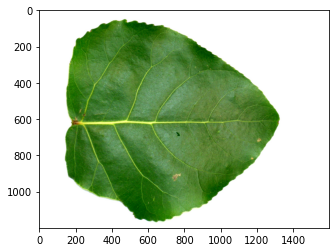

In [ ]:
img = None
img = cv.imread('./Data_Feuille/F26/3453.jpg')
img=cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
my_X = [img]

__Step 2__: Extract the SIFT feature (save to variable my_image_descriptors) and BoW (save to variable my_X_features) from my_X:

In [ ]:
my_image_descriptors = None
my_X_features = None
my_image_descriptors = extract_sift_features(my_X)
my_X_features = create_features_bow(my_image_descriptors, BoW, num_clusters)
print(len(my_image_descriptors))
print(my_image_descriptors[0].shape)
print(my_X_features[0].shape)
print(my_X_features[0])

1
(2693, 128)
(96,)
[ 38  22  45  17  10  14  10  18  10  31  18   3   9  10   4   3   8   4
  12   8  78  43   9  19  91   8  19  28   3  10  24   6   4  12  19   5
   9  15   6  17  55  23   5  17  19  11  18  12  15  18   8  14   4 549
  22  14   1   8  15  12  11   5  21  20  14  23   8  22  18   6   8   6
   6   4  15  15  20   3   7   3  14   7   3  19 226   7   5  11  17 478
  17  42   7  15   5  26]


__Step 3: __ Using the trained model to predict, the prediction result is stored in the variable my_y_pred

In [ ]:
y_pred = None
y_pred = svm.predict(my_X_features)
print(y_pred)
print('Loại lỗi: ' + classes[y_pred[0]])



[12]
Loại lỗi: F25
